In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.utils import resample
from utils import load_checkpoint

In [103]:
from model import AttentionModel
from dataset import TextDataset

In [104]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [4]:
data_path = '../data'
model_path = '../model'

In [5]:
df_ = pd.read_csv(os.path.join(r'E:\NLP\Vietnamese-Text-Classification-master\data\test.csv'))

In [6]:
drop_columns=['Date','Author(s)','Tags','URL']
train_data = df_.drop(columns=drop_columns)
train_data.head(10)

,Title,Summary,Contents,Category
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","Trong đó, ảnh hưởng nặng nhất là các tỉnh Sơn ...",Thời sự
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông tin tại hội nghị cho biết, năm 2019, tổn...",Kinh doanh
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"Sau lượt trận sớm vòng 4, bảng xếp hạng V.Leag...",Thể thao
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"Ngày 27.2.1955, Chủ tịch Hồ Chí Minh đã đích t...",Sức khỏe
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi với PV Lao Động, ông Nguy...",Pháp luật
5,"Chiến sĩ PCCC nói dối để cứu người, nữ thực tậ...",Chiến sĩ PCCC đã phải nói dối để trấn an người...,"Trong khi đó, thực tập sinh Phan Thị Hiên (21 ...",Diễn đàn
6,"Những chiêu trò lừa đảo, chiếm đoạt tiền phổ b...",Lợi dụng thời điểm cận Tết người dân có nhiều ...,Thủ đoạn lấy cắp thông tin ngân hàng Anh Lê Ho...,Xã hội
7,Tottenham vs Dortmund: Chờ đợi màn đôi công má...,"Vào lúc 3h rạng sáng 14.2, Tottenham sẽ tiếp đ...","Tottenham đang có phong độ khá tốt gần đây, 3 ...",Thể thao
8,Lãnh đạo lâm trường bị đối tượng vi phạm dùng ...,"Ngày 17.10, Lâm trường Đồng Hới (Quảng Bình) c...","Theo đó, vào khoảng 9h30 ngày 16.10, trong khi...",Pháp luật
9,"Google và Amazon giải quyết mâu thuẫn, đưa You...",Amazon (NASDAQ: AMZN) và Google (NASDAQ: GOOGL...,Google sẽ đưa YouTube trở lại các thiết bị Fir...,Kinh doanh


In [7]:
def display_missing(df,features_columns):
    n_rows=df.shape[0]
    for col in features_columns:
        missing_count=df[col].isnull().sum()
        if missing_count>0:
            print(f"{col} has {missing_count} missing values")
column_names = train_data.columns
print("Train:",display_missing(train_data,column_names))

Summary has 5 missing values
Contents has 91 missing values
Train: None


In [8]:
train_data = train_data.dropna(subset=['Contents'])
train_data = train_data.dropna(subset=['Summary'])

In [9]:
print("Train:",display_missing(train_data,column_names))

Train: None


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_data['Category'] = label_encoder.fit_transform(train_data['Category'])

In [11]:
train_data.head(10)

,Title,Summary,Contents,Category
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","Trong đó, ảnh hưởng nặng nhất là các tỉnh Sơn ...",18
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông tin tại hội nghị cho biết, năm 2019, tổn...",7
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"Sau lượt trận sớm vòng 4, bảng xếp hạng V.Leag...",17
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"Ngày 27.2.1955, Chủ tịch Hồ Chí Minh đã đích t...",14
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi với PV Lao Động, ông Nguy...",12
5,"Chiến sĩ PCCC nói dối để cứu người, nữ thực tậ...",Chiến sĩ PCCC đã phải nói dối để trấn an người...,"Trong khi đó, thực tập sinh Phan Thị Hiên (21 ...",4
6,"Những chiêu trò lừa đảo, chiếm đoạt tiền phổ b...",Lợi dụng thời điểm cận Tết người dân có nhiều ...,Thủ đoạn lấy cắp thông tin ngân hàng Anh Lê Ho...,25
7,Tottenham vs Dortmund: Chờ đợi màn đôi công má...,"Vào lúc 3h rạng sáng 14.2, Tottenham sẽ tiếp đ...","Tottenham đang có phong độ khá tốt gần đây, 3 ...",17
8,Lãnh đạo lâm trường bị đối tượng vi phạm dùng ...,"Ngày 17.10, Lâm trường Đồng Hới (Quảng Bình) c...","Theo đó, vào khoảng 9h30 ngày 16.10, trong khi...",12
9,"Google và Amazon giải quyết mâu thuẫn, đưa You...",Amazon (NASDAQ: AMZN) và Google (NASDAQ: GOOGL...,Google sẽ đưa YouTube trở lại các thiết bị Fir...,7


In [12]:
question  = train_data

In [13]:
question['length'] = [len(item) for item in list(question['Contents'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['Contents'])]

In [14]:
print(question)

                                                  Title  \
0     Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...   
1     Kiên Giang: Xúc tiến thương mại qua đường hàng...   
2     Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...   
3      Những lời chúc ngày Thầy thuốc Việt Nam hay nhất   
4     TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...   
...                                                 ...   
4995  Nguyên chủ tịch xã bị bắt vì cấp đất cho người...   
4996  Thêm một trường đại học cho sinh viên đến trườ...   
4997  Khu nhà ở công nhân thành điểm nóng lây COVID-...   
4998     Truy đuổi 100km bắt đối tượng tông xe vào CSGT   
4999  Trung Quốc công bố loạt ảnh khoa học đầu tiên ...   

                                                Summary  \
0     Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...   
1     Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...   
2     Báo Lao Động xin gửi tới quý độc giả link xem ...   
3     Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...

In [15]:
np.mean(question['num_word'])

511.3964110929853

(array([4.697e+03, 1.910e+02, 3.000e+00, 8.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([5.0000e+00, 1.0714e+03, 2.1378e+03, 3.2042e+03, 4.2706e+03,
        5.3370e+03, 6.4034e+03, 7.4698e+03, 8.5362e+03, 9.6026e+03,
        1.0669e+04]),
 <BarContainer object of 10 artists>)

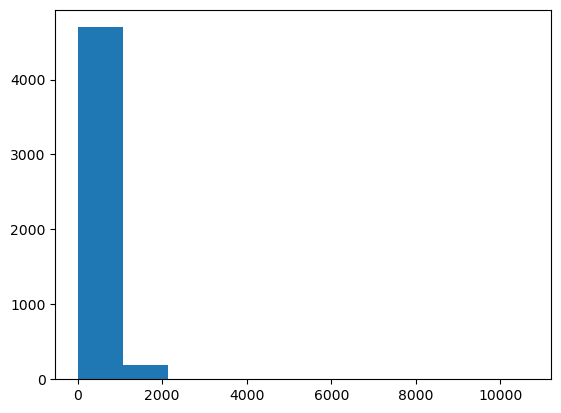

In [16]:
plt.hist(list(question['num_word']), bins = 10)

In [17]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [18]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['Contents']))

In [19]:
print(counts.items())

dict_items([('Trong', 3045), ('đó', 8962), (',', 135958), ('ảnh_hưởng', 1065), ('nặng', 586), ('nhất', 3895), ('là', 17983), ('các', 24510), ('tỉnh', 5203), ('Sơn_La', 149), ('Yên_Bái', 103), ('sau', 4479), ('Lai_Châu', 54), ('Bắc_Kạn', 33), ('Cao', 104), ('Bằng', 186), ('Điện_Biên', 118), ('Lào_Cai', 114), ('đã', 16476), ('xảy', 1321), ('ra', 6644), ('nhiều', 6918), ('vụ', 1266), ('sạt_lở', 153), ('nghiêm_trọng', 330), ('làm', 4545), ('người', 13068), ('bị', 4676), ('chết', 428), ('mất_tích', 100), ('và', 30919), ('bị_thương', 252), (';', 6332), ('công_trình', 574), ('nhà_cửa', 39), ('hoa_màu', 20), ('thiệt_hại', 335), ('.', 72736), ('Để', 590), ('kịp_thời', 518), ('hỗ_trợ', 1921), ('nhân_dân', 722), ('vùng', 1165), ('trực_tiếp', 1058), ('do', 3113), ('thiên_tai', 182), ('gây', 1619), ('sớm', 764), ('khắc_phục', 363), ('khó_khăn', 1558), ('ổn_định', 575), ('cuộc_sống', 502), ('Thường_trực', 241), ('Thành_ủy', 136), ('Hội_đồng', 471), ('Ủy_ban', 428), ('Mặt_trận', 54), ('Tổ_quốc', 120)

In [20]:
from collections import Counter
with open("file.txt", 'w', encoding='utf-8') as f:
    for key, value in counts.items():
        f.write(f"{key}: {value},")

In [21]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 54979
num_words after: 29325


In [22]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [23]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [24]:
print(words)

['', 'UNK', 'Trong', 'đó', ',', 'ảnh_hưởng', 'nặng', 'nhất', 'là', 'các', 'tỉnh', 'Sơn_La', 'Yên_Bái', 'sau', 'Lai_Châu', 'Bắc_Kạn', 'Cao', 'Bằng', 'Điện_Biên', 'Lào_Cai', 'đã', 'xảy', 'ra', 'nhiều', 'vụ', 'sạt_lở', 'nghiêm_trọng', 'làm', 'người', 'bị', 'chết', 'mất_tích', 'và', 'bị_thương', ';', 'công_trình', 'nhà_cửa', 'hoa_màu', 'thiệt_hại', '.', 'Để', 'kịp_thời', 'hỗ_trợ', 'nhân_dân', 'vùng', 'trực_tiếp', 'do', 'thiên_tai', 'gây', 'sớm', 'khắc_phục', 'khó_khăn', 'ổn_định', 'cuộc_sống', 'Thường_trực', 'Thành_ủy', 'Hội_đồng', 'Ủy_ban', 'Mặt_trận', 'Tổ_quốc', 'Việt_Nam', 'thành_phố', 'Hà_Nội', 'quyết_định', 'phía', 'Bắc', 'để', 'hậu_quả', 'mưa_lũ', 'gia_đình', 'nạn_nhân', '\n', 'Cụ_thể', ':', 'Hỗ_trợ', 'nặng_nề', 'gồm', 'mỗi', '1', 'tỉ', 'đồng', '500', 'triệu', 'có', 'ở', 'địa_phương', 'nêu', 'trên', '10', '5', 'Tiền', 'được', 'trích', 'từ', 'Quỹ', 'Cứu_trợ', 'của', 'Thông_tin', 'tại', 'hội_nghị', 'cho', 'biết', 'năm', '2019', 'tổng_số', 'lượt', 'khách', 'du_lịch', 'đến', 'Kiên_Giang'

In [25]:
N = 22
question['encoded'] = question['Contents'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

,Title,Summary,Contents,Category,length,num_word,encoded
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","Trong đó, ảnh hưởng nặng nhất là các tỉnh Sơn ...",18,1009,226,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 4, 12, 4, 13..."
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông tin tại hội nghị cho biết, năm 2019, tổn...",7,3755,794,"[[97, 98, 99, 100, 101, 4, 102, 103, 4, 104, 1..."
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"Sau lượt trận sớm vòng 4, bảng xếp hạng V.Leag...",17,862,187,"[[342, 105, 343, 49, 344, 345, 4, 346, 347, 34..."
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"Ngày 27.2.1955, Chủ tịch Hồ Chí Minh đã đích t...",14,2549,560,"[[412, 1, 4, 423, 424, 20, 425, 288, 426, 427,..."
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi với PV Lao Động, ông Nguy...",12,1748,387,"[[602, 603, 4, 604, 117, 605, 606, 4, 368, 607..."


In [26]:
column_to_check = 'encoded'
if isinstance(question[column_to_check].values, np.ndarray):
    print(f"Cột '{column_to_check}' là một mảng NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải là một mảng NumPy.")

Cột 'encoded' là một mảng NumPy.


In [27]:
column_name = 'encoded'
numpy_array = question[column_name].values
shape_column = numpy_array.shape
shape_column

(4904,)

In [28]:
column_to_check = 'encoded'
numpy_array = question[column_to_check].values
dtype_column = numpy_array.dtype
print(dtype_column)

if dtype_column == 'object':
    print(f"Cột '{column_to_check}' có dạng chuỗi (string) trong NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải dạng chuỗi (string) trong NumPy.")

object
Cột 'encoded' có dạng chuỗi (string) trong NumPy.


In [29]:
unique_values = train_data['Category'].unique()
len(unique_values)

26

In [30]:
question.to_csv(r'E:\NLP\Vietnamese-Text-Classification-master\datatrain_tokenized.csv', index=False,header=False)

In [31]:
X = list(question['encoded'])
y = list(question['Category'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=42)

In [32]:
print(X[:1])

[array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  4, 12,  4, 13,  3,  8,
         9, 10, 14,  4, 15,  4]])]


In [67]:
unique_values = list(set(y))

print(unique_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [68]:
len(X_train),len(X_valid)

(3678, 1226)

In [73]:
class_weights = torch.tensor(y_train,dtype=torch.float)
class_weights

tensor([ 7.,  6., 25.,  ..., 11.,  7., 25.])

In [113]:
train_ds = TextDataset(X_train, y_train)
print(train_ds)
valid_ds = TextDataset(X_valid, y_valid)

In [114]:
batch_size = 30
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [115]:
model = AttentionModel(
                    output_size=class_weights.shape[0], 
                    hidden_size=128, 
                    vocab_size=vocab_size, 
                    embedding_length=400
                    )

In [116]:
model = model.train()
model.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [108]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [109]:
def train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    list_pred = []
    for x, y in train_dl:
        y = y.type(torch.int64)
        x = x.long()

        y_pred = model(x)

        optimizer.zero_grad()


        loss = criterion(y_pred,y)
        
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        list_pred.append(y_pred.argmax())
    return epoch_loss / len(train_dl)

In [110]:
def evaluate_one_epoch(model, valid_dl,criterion,writer,epoch):
    model.eval()
    epoch_acc = 0
    epoch_loss = 0
    list_true = []
    list_pred = []
    with torch.no_grad():
        for x, y in valid_dl:
            y = y.type(torch.int64)
            x = x.long()
            y_hat = model(x)
#             acc = binary_accuracy(y_hat,y)
            loss = criterion(y_hat,y)
            writer.add_scalar("Loss/valid", loss, epoch)
            epoch_loss += loss.item()

    return epoch_loss/len(valid_dl)

Epoch-0 lr: 0.001
	Train Loss: 1.616 | Valid Loss: 1.804
Epoch-1 lr: 0.001
	Train Loss: 1.264 | Valid Loss: 1.694
Epoch-2 lr: 0.001
	Train Loss: 0.986 | Valid Loss: 1.661


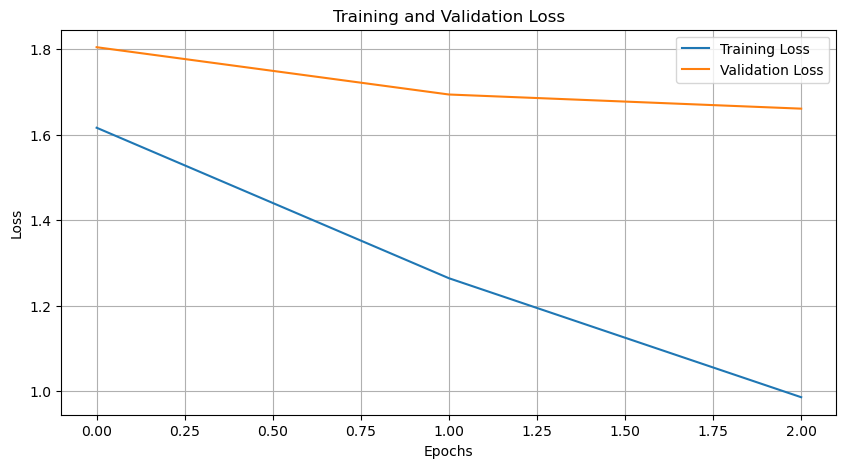

In [112]:
import matplotlib.pyplot as plt

loss = []
val_loss = []
valid_loss_min=0

# Vòng lặp training
for epoch in range(3):
    train_loss = train_one_epoch(model, train_dl, optimizer, criterion, writer, epoch)
    valid_loss = evaluate_one_epoch(model, val_dl, criterion, writer, epoch)
    
    print(f'Epoch-{epoch} lr: {optimizer.param_groups[0]["lr"]}')
    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    # Lưu train_loss và valid_loss vào list để vẽ đồ thị sau này
    loss.append(train_loss)
    val_loss.append(valid_loss)

    # Lưu train_loss và valid_loss vào file .txt
    with open('losses.txt', 'a') as file:
        file.write(f'Epoch {epoch}: Train Loss - {train_loss:.3f}, Valid Loss - {valid_loss:.3f}\n')

    # Lưu checkpoint nếu valid_loss giảm
    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        checkpoint = {
            'model': model,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(model_path, f'checkpoint_{valid_loss_min:.3f}.pth'))
    
    exp_lr_scheduler.step()

# Vẽ biểu đồ loss và valid_loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()


In [ ]:
torch.save(model.state_dict(), "text_classification.pt")